# Practice Session 05: PageRank

*Introduction to Network Science* (2025/26), UPF

# 1. Read host names

In [1]:
# Imports — leave as is

import gzip
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Input file locations — you might need to change these depending on where you stored your files

INPUT_NODES_FILENAME = "data/webspam-uk2007/webspam_uk2007-nodes.csv.gz"
INPUT_EDGES_FILENAME = "data/webspam-uk2007/webspam_uk2007-edges.csv.gz"

In [3]:
hosts = {}
name2id = {}

with gzip.open(INPUT_NODES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file)
    for line in reader:
        name_label = {}
        name_label["name"] = line["hostname"]
        name_label["label"] = line["label"]
        id = int(line["nodeid"])
        hosts[id] = name_label
        name2id[line["hostname"]] = id


In [4]:
# Leave as-is

print("Number of hosts: %s" % len(hosts))
print("%s: %s" % (hosts[873]['name'], hosts[873]['label']))
print("%s: %s" % (hosts[105715]['name'], hosts[105715]['label']))

Number of hosts: 114529
bbc.co.uk: nonspam
www.top-mobile-phones.co.uk: spam


Next, print how many hosts and what percentage have label `spam`, `nonspam`, and `unlabeled`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [5]:
unlabaeled_count = 0
spam_count = 0
nonspam_count = 0

for id, name_label in hosts.items():
    if name_label["label"] == "unlabeled":
        unlabaeled_count += 1
    elif name_label["label"] == "spam":
        spam_count += 1
    elif name_label["label"] == "nonspam":
        nonspam_count += 1
        
print("Unlabeled hosts: %s" % unlabaeled_count, "("+ str(round(unlabaeled_count/len(hosts)*100,2)) + "%)")
print("Spam hosts: %s" % spam_count, "("+ str(round(spam_count/len(hosts)*100,2)) + "%)")
print("Non-spam hosts: %s" % nonspam_count, "("+ str(round(nonspam_count/len(hosts)*100,2)) + "%)")

Unlabeled hosts: 108476 (94.71%)
Spam hosts: 344 (0.3%)
Non-spam hosts: 5709 (4.98%)


Now let's explore a small part of the graph. For this, you will need to open the file `INPUT_EDGES_FILENAME` which contains columns `source`, `destination`, and `weight` indicating that some pages in host id `source` point to pages in host id `destination`. The number of such pages is the `weight`.

The graph is too large so we will focus on three categories that tend to be heavily spammed: shopping, financial services and adult content. We will filter by the following keywords:

```python
    spammywords = ['credit', 'free', 'mortgage', 'jackpot', 'casino', 'wealthy', 'luxury', 'shop', 'replica', 'finance', 'debt', 'loan', 'discount', 'escort', 'xx', 'girl', 'mistress', 'important', 'attention']
```

Now, create a directed graph (a NetworkX `DiGraph()`) containing all the edges that fulfil ***all three* of the following conditions**:

1. The source contains one of the `spammywords` **or** the destination contains one of the `spammywords` (you can check substring membership easily with the [`in` operator](https://mimo.org/glossary/python/in-operator))
1. The source is labeled as either `spam` or `nonspam`
1. The destination is labeled as either `spam` or `nonspam`

Your graph should have nodes that are hostnames, so whenever you find such an edge in the input file, you should do:

```python
    g.add_edge(hosts[source]['name'], hosts[destination]['name'])
```

Print the number of nodes in the resulting graph, it should be less than 200.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [6]:
spammywords = [
    'credit', 'free', 'mortgage', 'jackpot', 'casino', 'wealthy', 'luxury', 
    'shop', 'replica', 'finance', 'debt', 'loan', 'discount', 'escort', 
    'xx', 'girl', 'mistress', 'important', 'attention']

g = nx.DiGraph()

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file)
    for row in reader:
        source_id = int(row['source'])
        target_id = int(row['destination'])
        source_name = hosts[source_id]['name']
        target_name = hosts[target_id]['name']

        if (
            (any(word in source_name for word in spammywords)
            or any(word in target_name for word in spammywords))
            and hosts[source_id]['label'] != 'unlabeled'
            and hosts[target_id]['label'] != 'unlabeled'
        ):
            g.add_edge(source_name, target_name)

print("Number of nodes:", g.number_of_nodes())
print("Number of edges:", g.number_of_edges())

Number of nodes: 172
Number of edges: 155


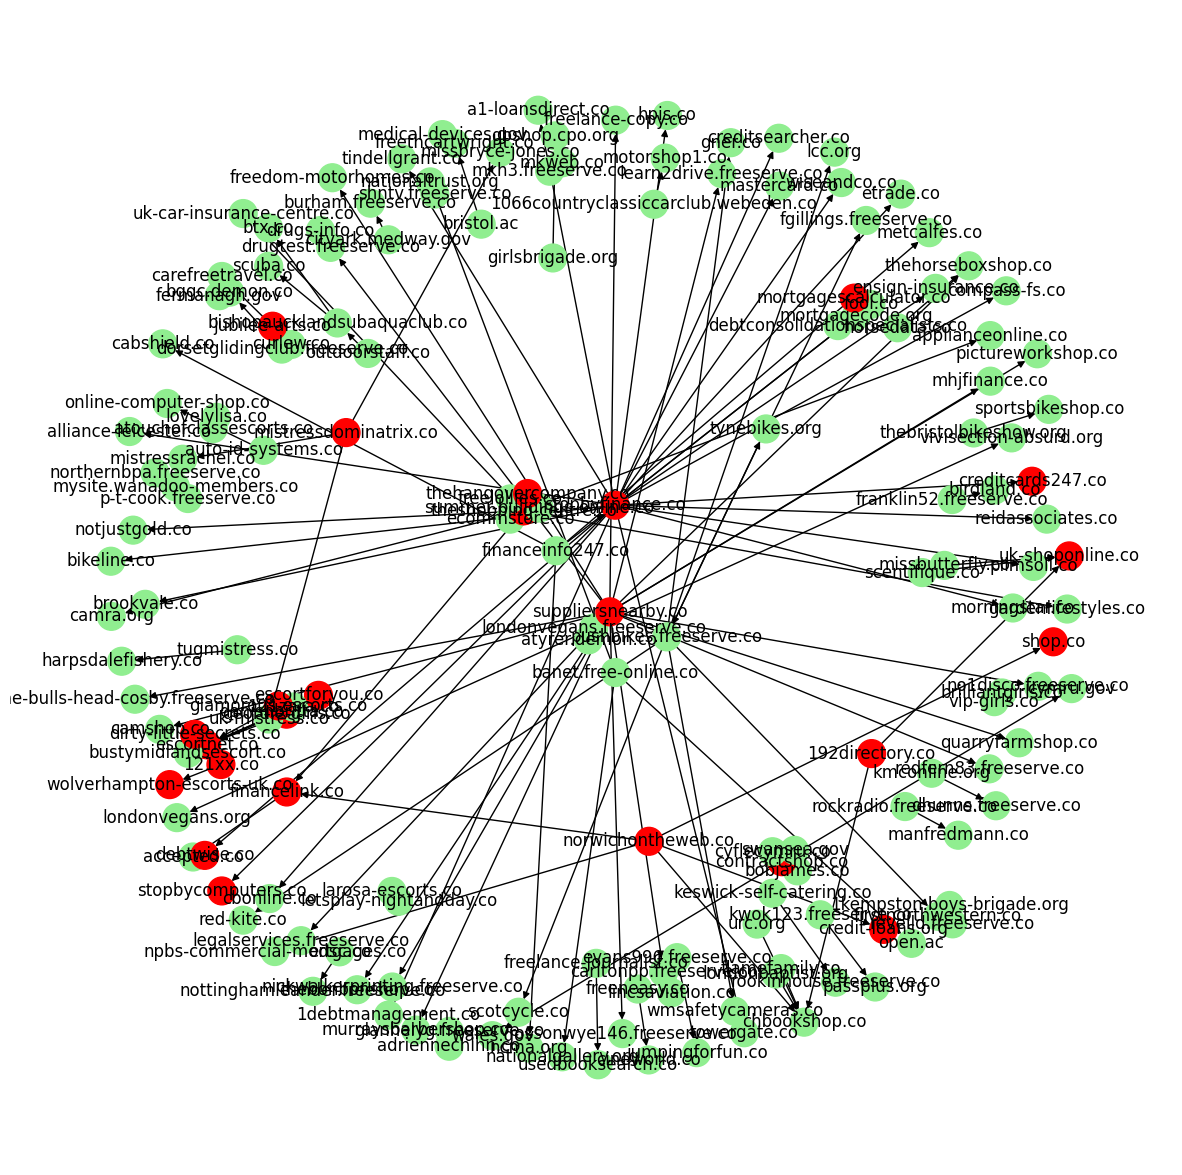

In [7]:
# Leave this code as-is, or modify slightly

colors = []
hostname_converted = {}

for hostname in g.nodes():
    # Assign colors to nodes according to spam/nonspam labels
    if hosts[name2id[hostname]]['label'] == 'spam':
        colors.append('red')
    elif hosts[name2id[hostname]]['label'] == 'nonspam':
        colors.append('lightgreen')
    else:
        colors.append('white')

    # Shorten the hostnames to generate labels
    label = hostname.replace("www.", "").replace(".uk", "")
    hostname_converted[hostname] = label

# Notice that if you re-run this cell the layout will be different every time
plt.figure(figsize=(15, 15))
plt.axis('off')
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=400, node_color=colors, labels=hostname_converted)

I see some hubs in the middle of the graph, which has a roughly circuluar structure. Composed mainly of high degree nodes on the inside and low degree leafs on the outside. I assume the red nodes are spammy and the green aren't. The hubs have very high out-degree, they dont seem to have many, if any, incoming edges. The graph is heterogeneous, meaning its edge distribution would have that signature "long tail" that is associated with networks that have hubs.

Let's use this example as a brief exercise to cement the theory, in particular the difference between conditional and joint probabilities and how these apply to edges on a network.

You should calculate the following probabilities (keep in mind edges are directed):
* The (marginal) probability of observing and edge A->B where A is a spam node.
* The (joint) probability of observing a spam->nonspam edge in the network.
* The (conditional) probability of observing a spam->nonspam edge, *given that* we start from a spam node.

Write some code to calculate these probabilities. It should take no more than a few lines of code. Think simple!

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [8]:
spam_edge = 0
spam_nonspam_edge = 0
spam_source_count = 0
nonspam_target_count = 0

for edge in g.edges():
    source_name = edge[0]
    source_id = name2id[source_name]
    if hosts[source_id]['label'] == 'spam':
        spam_edge += 1
p_spam_edge = round(spam_edge / g.number_of_edges(), 4)

for edge in g.edges():
    source_name = edge[0]
    target_name = edge[1]
    source_id = name2id[source_name]
    target_id = name2id[target_name]
    if hosts[source_id]['label'] == 'spam' and hosts[target_id]['label'] == 'nonspam':
        spam_nonspam_edge += 1
p_spam_nonspam_edge = round(spam_nonspam_edge / g.number_of_edges(), 4)

for edge in g.edges():
    source_name = edge[0]
    target_name = edge[1]
    source_id = name2id[source_name]
    target_id = name2id[target_name]
    if hosts[source_id]['label'] == 'spam':
        spam_source_count += 1
        if hosts[target_id]['label'] == 'nonspam':
            nonspam_target_count += 1

pcond_spam_nonspam_edge = round(nonspam_target_count / spam_source_count, 4)


print("P(edge leaving from spammy node): ", p_spam_edge)
print("P(edge pointing from spammy to non-spammy node): ", p_spam_nonspam_edge)
print("P(source is spammy | target is non-spammy): ", pcond_spam_nonspam_edge)

P(edge leaving from spammy node):  0.4968
P(edge pointing from spammy to non-spammy node):  0.3806
P(source is spammy | target is non-spammy):  0.7662


Overall, yes they do make sense to me. However, I had to look carefully at the network to see where these numebers were coming from. The last value made immediate sense since just by looking at the network for a few seconds you notice that nearly every edge originates at a spammy hub and arrives at a non spammy leaf. Thats simply the structure of the graph. For the first two values, it isnt until you see the many non-spam nodes that are connected to eachother by short, hidden edges that these values start to make sense. Initially it seems like the odds of these two events are way higher than their true values but once you look at the amount of edges between green nodes it starts to make sense.

# 2. Compute the degree of each node

Compute the **out-degree** of each node and store it in a dictionary `id2degree`. (Remember we need this for the PageRank algorithm.) 

Do this while reading the edges file, without storing the graph in main memory. Remember that this file contains ``source``, ``destination``, ``weight`` records.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [9]:
# Leave this code as-is

# Initialize id2degree dict
id2degree = {}
N = len(hosts)
for nodeid in range(N):
    id2degree[nodeid] = 0

In [10]:
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file)
    for row in reader:
        source_id = int(row['source'])
        id2degree[source_id] += 1

print(id2degree.values())

    

dict_values([46, 0, 3, 1, 1, 10, 2, 0, 6, 0, 0, 0, 6, 0, 7, 12, 1, 0, 4, 2, 22, 0, 222, 1, 0, 5, 0, 1, 3, 0, 0, 1, 10, 1, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 9, 4, 0, 4, 9, 0, 2, 1, 1, 0, 3, 5, 11, 0, 0, 258, 14, 7, 0, 0, 0, 1, 0, 4, 6, 2, 0, 1, 3, 1, 0, 6, 4, 0, 1, 10, 1, 1, 3, 2, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 4, 0, 0, 6, 1, 0, 2, 3, 8, 32, 1, 1, 0, 0, 4, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 10, 0, 5, 0, 0, 4, 0, 0, 0, 20, 0, 2, 1, 1, 11, 0, 1, 9, 11, 0, 1, 0, 0, 0, 6, 1, 0, 1, 0, 75, 0, 4, 0, 5, 0, 3, 0, 2, 4, 16, 7, 0, 5, 0, 0, 1, 4, 2, 0, 0, 4, 0, 10, 5, 1, 8, 5, 0, 4, 1, 5, 1, 1, 0, 1, 8, 0, 18, 1, 0, 4, 114, 1, 3, 5, 1, 0, 0, 1, 3, 1, 0, 2, 5, 0, 2, 3, 1, 0, 0, 5, 10, 0, 12, 1, 51, 6, 60, 0, 1, 7, 1, 1, 0, 1, 1, 34, 7, 1, 1, 0, 0, 0, 10, 2, 21, 1, 8, 7, 8, 1224, 1, 272, 2, 2, 0, 2, 35, 44, 1, 2, 4, 0, 1, 62, 1, 1, 4, 8, 6, 3, 1, 3, 1, 19, 1, 4, 0, 0, 6, 1, 16, 0, 1, 37, 0, 2, 1, 2, 10, 0, 53, 1, 0, 2, 17, 51, 49, 1, 0, 0, 2, 2, 0, 21, 1, 75, 50, 1, 50, 1, 1, 273,

In [11]:
# Leave this cell as-is

for nodeid in [61914, 479, 62730]:
    print(f"{hosts[nodeid]['name']}: degree {id2degree[nodeid]}")

www.instrumentfinance.co.uk: degree 262
amazon.co.uk: degree 6
www.iso9000uk.co.uk: degree 38


# 3. Compute PageRank

Perform `ITERATIONS=25` iterations with `ALPHA=0.91`. In each iteration, you will read the file of the graph, **without loading the entire graph in memory**. This means each iteration involves opening (and implicitly, closing) the edges file.

Your code should do the following:

* At the beginning, initialize the vector `pagerank` as a vector of 1/N and the vector `pagerank_aux` as a vector of 0s.
* For `iterations` iterations:
   * Read the graph and for every link from *source* to *destination*:
      * Add to `pagerank_aux[destination]` the value `pagerank[source]/degree`, where `degree` is the out-degree of the source node (i.e, its number of out-links).
   * Set `pagerank` of every node to `alpha x pagerank_aux + (1.0-alpha) x (1.0/N)`.
   * Normalize the values of `pagerank` so they add up to 1.0
   * Compute and print `delta` as the sumation of the absolute changes in PageRank between this iteration and the previous one; this value should decrease from one iteration to the next
   * Set `pagerank_aux` to 0.0

Remember: do not keep the graph in memory, because that will limit the size of the graphs your code can handle. At every iteration you must read the file again. You can use the following template:

```python
for iteration in range(ITERATIONS):
    print(f"Iteration {iteration+1} of {ITERATIONS}")
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        ...

```

After each iteration, print the `delta` with 4 decimals. This sum should be, in general, decreasing.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [12]:
# Leave this cell as-is

ITERATIONS = 25
ALPHA = 0.91

pagerank = [1.0/N] * N
pagerank_aux = [0.0] * N

In [13]:
for iteration in range(ITERATIONS):
    print("Iteration", iteration + 1, "of", ITERATIONS)
    out_degree = [0] * N

    # compute out-degrees
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader)  # skip header
        for row in reader:
            out_degree[int(row[0])] += 1

    # distribute pagerank
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader) # skip header
        for row in reader:
            source, destination = int(row[0]), int(row[1])
            if out_degree[source]:
                pagerank_aux[destination] += pagerank[source] / out_degree[source]


    # update pagerank
    new_pagerank = []
    for i in range(N):
        new_value = ALPHA * pagerank_aux[i] + (1.0 - ALPHA) / N
        new_pagerank.append(new_value)


    #  normalize
    norm = 0.0
    for x in new_pagerank:
        norm += x

    for i in range(N):
        new_pagerank[i] = new_pagerank[i] / norm

    # new delta
    delta = 0.0
    for i in range(N):
        delta += abs(new_pagerank[i] - pagerank[i])

    print("  delta =", round(delta, 4))
    print("    sumPageRank =", round(sum(new_pagerank), 10)) # should be exactly 1
    pagerank, pagerank_aux = new_pagerank, [0.0] * N


Iteration 1 of 25
  delta = 1.1472
    sumPageRank = 1.0
Iteration 2 of 25
  delta = 0.4814
    sumPageRank = 1.0
Iteration 3 of 25
  delta = 0.2268
    sumPageRank = 1.0
Iteration 4 of 25
  delta = 0.1259
    sumPageRank = 1.0
Iteration 5 of 25
  delta = 0.0798
    sumPageRank = 1.0
Iteration 6 of 25
  delta = 0.0548
    sumPageRank = 1.0
Iteration 7 of 25
  delta = 0.04
    sumPageRank = 1.0
Iteration 8 of 25
  delta = 0.0302
    sumPageRank = 1.0
Iteration 9 of 25
  delta = 0.024
    sumPageRank = 1.0
Iteration 10 of 25
  delta = 0.0197
    sumPageRank = 1.0
Iteration 11 of 25
  delta = 0.0169
    sumPageRank = 1.0
Iteration 12 of 25
  delta = 0.0153
    sumPageRank = 1.0
Iteration 13 of 25
  delta = 0.0147
    sumPageRank = 1.0
Iteration 14 of 25
  delta = 0.0146
    sumPageRank = 1.0
Iteration 15 of 25
  delta = 0.0145
    sumPageRank = 1.0
Iteration 16 of 25
  delta = 0.0145
    sumPageRank = 1.0
Iteration 17 of 25
  delta = 0.0146
    sumPageRank = 1.0
Iteration 18 of 25
  delta

# 4. Nodes with largest values of PageRank

Print the top 20 hosts by PageRank, including the host name, and the PageRank value with 6 decimals.

You can use the `enumerate()` function which converts a list `[a, b, c]` into `[(0,a), (1,b), (2,c)]` and then `sort()` as follows. Suppose ``score`` contains ``[0.2, 0.7, 0.4]``:

```python
hosts_by_score = sorted(enumerate(score), key=lambda x: x[1], reverse=True)
```

Will return the list `[(1,0.7), (2,0.4), (0,0.2)]`

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [14]:
def print_top_hosts(hosts, pagerank):
    hosts_by_score = sorted(enumerate(pagerank), key=lambda x: x[1], reverse=True)
    
    print("Top 20 hosts by PageRank:")
    print("{:<5} {:<30} {:>10}".format("Rank", "Host", "PageRank"))
    print("-" * 50)

    for rank, (idx, score) in enumerate(hosts_by_score[:20], start=1):
        print(f"№{rank}. {hosts[idx]["name"]} ({hosts[idx]["label"]}): {score:.6f}")

print_top_hosts(hosts, pagerank)


Top 20 hosts by PageRank:
Rank  Host                             PageRank
--------------------------------------------------
№1. www.opsi.gov.uk (unlabeled): 0.006525
№2. www.ico.gov.uk (unlabeled): 0.003838
№3. www.adobe.co.uk (unlabeled): 0.003396
№4. www.kelkoo.co.uk (unlabeled): 0.003389
№5. www.dti.gov.uk (unlabeled): 0.003127
№6. www.alcoholics-anonymous.org.uk (unlabeled): 0.003107
№7. www.defra.gov.uk (unlabeled): 0.003014
№8. shopping.kelkoo.co.uk (unlabeled): 0.002892
№9. www.aa-roundabout.org.uk (unlabeled): 0.002830
№10. www.direct.gov.uk (unlabeled): 0.002611
№11. www.communities.gov.uk (unlabeled): 0.002606
№12. www.dfes.gov.uk (unlabeled): 0.002486
№13. www.dh.gov.uk (unlabeled): 0.002120
№14. www.hmso.gov.uk (unlabeled): 0.001994
№15. news.bbc.co.uk (unlabeled): 0.001990
№16. www.fsa.gov.uk (unlabeled): 0.001952
№17. www.nationalrail.co.uk (unlabeled): 0.001902
№18. www.homeoffice.gov.uk (unlabeled): 0.001806
№19. www.hse.gov.uk (unlabeled): 0.001733
№20. www.dwp.gov.uk

1. I think these are the top ones because lots of people are required to access them, this is the case for most of the goverment websites on here. Meaning they dont wish to visit them but they have to. Also, there alcoholism is extremely widespread explaining the presence of the aa appearances. Finally the BBC is the UK most well known news outlet, so it would make sense that it is in this ranking.

2. I see 4 commercial, 3 educational and 13 government:
20% commercial
15% educational
65% government

# 5. Run non-spam PageRank

Now, write code and run non-spam PageRank. For this, simply ignore any link in which the source and the destination are known spam hosts.

You can query this with something like

```python
hosts[source]['label'] != "spam" and hosts[destination]['label'] != "spam"
```

For this, you first need to compute the "no-spam degree" of the nodes in a dictionary `id2nsdegree` ("ns" stands for **n**on-**s**pam), and use that in the PageRank algorithm.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [15]:
id2nsdegree = {}

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file)
    for row in reader:
        idsource = int(row['source'])
        iddestination = int(row['destination'])
        if hosts[idsource]['label'] != "spam" and hosts[iddestination]['label'] != "spam":
            if idsource in id2nsdegree:
                id2nsdegree[idsource] += 1
            else:
                id2nsdegree[idsource] = 1



In [16]:
# Leave this cell as-is

for nodeid in [61914, 479, 62730]:
    print(f"{hosts[nodeid]['name']}: normal degree {id2degree[nodeid]} nospam degree {id2nsdegree[nodeid]}")

www.instrumentfinance.co.uk: normal degree 262 nospam degree 258
amazon.co.uk: normal degree 6 nospam degree 6
www.iso9000uk.co.uk: normal degree 38 nospam degree 37


In [17]:
ns_pagerank = [1.0 / N] * N
pagerank_aux = [0.0] * N

for iteration in range(ITERATIONS):
    print("Iteration", iteration + 1, "of", ITERATIONS)
    
    # distribute pagerank
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            source, destination = int(row['source']), int(row['destination'])

            # skip spam nodes
            if hosts[source]['label'] == "spam" or hosts[destination]['label'] == "spam":
                continue

            # only distribute if source has nonzero out-degree
            if source in id2nsdegree and id2nsdegree[source] > 0:
                pagerank_aux[destination] += ns_pagerank[source] / id2nsdegree[source]

    # update pagerank
    new_pagerank = []
    for i in range(N):
        new_value = ALPHA * pagerank_aux[i] + (1.0 - ALPHA) / N
        new_pagerank.append(new_value)

    # normalize
    norm = sum(new_pagerank)
    new_pagerank = [x / norm for x in new_pagerank]

    # compute delta
    delta = sum(abs(new_pagerank[i] - ns_pagerank[i]) for i in range(N))

    print("  delta =", round(delta, 4))
    print("    sumPageRank =", round(sum(new_pagerank), 10)) # should be exactly 1

    # prepare for next iteration
    ns_pagerank, pagerank_aux = new_pagerank, [0.0] * N

Iteration 1 of 25
  delta = 1.148
    sumPageRank = 1.0
Iteration 2 of 25
  delta = 0.4816
    sumPageRank = 1.0
Iteration 3 of 25
  delta = 0.2267
    sumPageRank = 1.0
Iteration 4 of 25
  delta = 0.126
    sumPageRank = 1.0
Iteration 5 of 25
  delta = 0.0799
    sumPageRank = 1.0
Iteration 6 of 25
  delta = 0.0548
    sumPageRank = 1.0
Iteration 7 of 25
  delta = 0.04
    sumPageRank = 1.0
Iteration 8 of 25
  delta = 0.0303
    sumPageRank = 1.0
Iteration 9 of 25
  delta = 0.024
    sumPageRank = 1.0
Iteration 10 of 25
  delta = 0.0197
    sumPageRank = 1.0
Iteration 11 of 25
  delta = 0.0169
    sumPageRank = 1.0
Iteration 12 of 25
  delta = 0.0153
    sumPageRank = 1.0
Iteration 13 of 25
  delta = 0.0147
    sumPageRank = 1.0
Iteration 14 of 25
  delta = 0.0146
    sumPageRank = 1.0
Iteration 15 of 25
  delta = 0.0146
    sumPageRank = 1.0
Iteration 16 of 25
  delta = 0.0146
    sumPageRank = 1.0
Iteration 17 of 25
  delta = 0.0147
    sumPageRank = 1.0
Iteration 18 of 25
  delta =

In [18]:
print_top_hosts(hosts, ns_pagerank)

Top 20 hosts by PageRank:
Rank  Host                             PageRank
--------------------------------------------------
№1. www.opsi.gov.uk (unlabeled): 0.006532
№2. www.ico.gov.uk (unlabeled): 0.003839
№3. www.kelkoo.co.uk (unlabeled): 0.003398
№4. www.adobe.co.uk (unlabeled): 0.003397
№5. www.dti.gov.uk (unlabeled): 0.003130
№6. www.alcoholics-anonymous.org.uk (unlabeled): 0.003113
№7. www.defra.gov.uk (unlabeled): 0.003015
№8. shopping.kelkoo.co.uk (unlabeled): 0.002899
№9. www.aa-roundabout.org.uk (unlabeled): 0.002836
№10. www.direct.gov.uk (unlabeled): 0.002611
№11. www.communities.gov.uk (unlabeled): 0.002609
№12. www.dfes.gov.uk (unlabeled): 0.002490
№13. www.dh.gov.uk (unlabeled): 0.002125
№14. www.hmso.gov.uk (unlabeled): 0.001997
№15. news.bbc.co.uk (unlabeled): 0.001991
№16. www.fsa.gov.uk (unlabeled): 0.001953
№17. www.nationalrail.co.uk (unlabeled): 0.001903
№18. www.homeoffice.gov.uk (unlabeled): 0.001807
№19. www.hse.gov.uk (unlabeled): 0.001734
№20. www.dwp.gov.uk

# 6. Compute spam gain

Finally, compute the gain of every host as *(Normal PageRank) / (No spam PageRank)*.

Among the top 50 hosts you might find many "spam" (business that look ilegitimate or that tend to rely on spam such as gambling, pornography, counterfeits, and scams). You might also find "normal" sites (i.e., websites that look legitimate), because spammers also point to legitimate sites to disguise their actions.

For each of the top 50 hosts, print the following:

* The hostname
* Its label (spam/nonspam)
* Their gain *(Normal PageRank) / (No spam PageRank)* with two decimals (e.g., "3.22")
* Their PageRank in scientific notation with two significant digits (e.g., "5.8e-06")
* Their no-spam-PageRank in scientific notation with two significant digits (e.g., "5.8e-06")

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to print the top 50 hosts by spam gain.</font>

<font size="+1" color="red">Replace this cell with a brief explanation, in your own words, of what the spam gain means, what kind of websites have the most spam gain, and what are the effects of using non-spam PageRank.</font>

# Deliver (individually)

A `.zip` file containing:

* This notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>